# Private Housing Resale Price Prediction
This file is dedicated to predicting private housing resale prices.

## Data Collection
- The following codes below in this section is dedicated to reading and combining csv files into 1 dataframe.
- We also import all necessary modules in this section as well.
- Data is retrieved from Private Residential Property Transactions from https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action .

In [56]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import glob
import xgboost as xg
import pickle


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [57]:
# Read csv files for private housing data
privateHouseFile = "../dataset/sale-prediction/private-housing/*.csv"
all_private_sales = glob.glob(privateHouseFile)

listOfPrivate = []
for filename in all_private_sales:
    df = pd.read_csv(filename, skiprows=1)
    listOfPrivate.append(df)

privateDf = pd.concat(listOfPrivate, axis=0)
privateDf.reset_index(drop=True, inplace=True)
privateDf.head()

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,1,ECHELON,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2012,Resale,1.0,2000000.0,-,93.0,Strata,41 to 45,21505.0,May-2021
1,2,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,04,RCR,99 yrs lease commencing from 1999,Resale,1.0,2300000.0,-,141.0,Strata,01 to 05,16312.0,May-2021
2,3,LUMIERE,MISTRI ROAD,Apartment,02,CCR,99 yrs lease commencing from 2006,Resale,1.0,1251300.0,-,60.0,Strata,36 to 40,20855.0,May-2021
3,4,ASCENTIA SKY,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2008,Resale,1.0,2530000.0,-,169.0,Strata,16 to 20,14970.0,May-2021
4,5,HUNDRED TREES,WEST COAST DRIVE,Condominium,05,OCR,956 yrs lease commencing from 1928,Resale,1.0,1150000.0,-,73.0,Strata,01 to 05,15753.0,May-2021


### Exploratory Data Analysis (EDA)
- In this section, we will examine the data that we have collected earlier.
- We will check data types of columns, check any outliers, visualising correlations between features and etc.

In [58]:
# Checks how many rows/columns are there
# There are 63895 rows and 16 columns
privateDf.shape

(63895, 16)

In [59]:
# Check data types of columns
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63895 entries, 0 to 63894
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S/N                63748 non-null  object 
 1   Project Name       63853 non-null  object 
 2   Street Name        63619 non-null  object 
 3   Type               63618 non-null  object 
 4   Postal District    63618 non-null  object 
 5   Market Segment     63601 non-null  object 
 6   Tenure             63597 non-null  object 
 7   Type of Sale       63601 non-null  object 
 8   No. of Units       63601 non-null  float64
 9   Price ($)          63601 non-null  float64
 10  Nett Price ($)     63601 non-null  object 
 11  Area (Sqm)         63601 non-null  float64
 12  Type of Area       63601 non-null  object 
 13  Floor Level        63601 non-null  object 
 14  Unit Price ($psm)  63601 non-null  float64
 15  Date of Sale       63601 non-null  object 
dtypes: float64(4), object(

In [60]:
# Find out mean, median, standard deviation, etc
privateDf.describe()

,No. of Units,Price ($),Area (Sqm),Unit Price ($psm)
count,63601.000000,6.360100e+04,63601.000000,63601.000000
mean,1.104951,2.349279e+06,164.658873,13938.754139
std,4.725084,1.242689e+07,747.378357,5505.148333
min,1.000000,4.000000e+04,24.000000,355.000000
25%,1.000000,1.005000e+06,89.000000,10194.000000
50%,1.000000,1.428000e+06,116.000000,12773.000000
75%,1.000000,2.300000e+06,159.000000,16400.000000
max,560.000000,9.800000e+08,87986.000000,64848.000000


The following boxplot graphs below will help us to visualise data better instead of using the 'describe' function used earlier.

Legend (Market Segment)
- Core Central Region (CCR)
- Rest of Central Region (RCR)
- Outside Central Region (OCR)
- Reference: https://spring.ura.gov.sg/lad/ore/login/map_ccr.pdf

(0.0, 10000000.0)

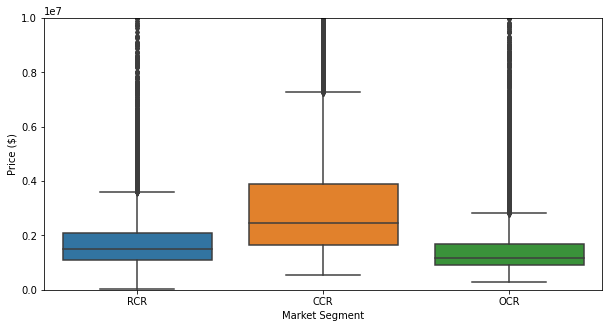

In [61]:
# Need to speicfy figure size before displaying boxplot below
plt.figure(figsize=[10,5])

sns.boxplot(x="Market Segment", y="Price ($)", data=privateDf)
# Max value is 10 million dollars
plt.ylim(0,10000000)

# From the boxplot below, we can tell that the CCR region median is higher than RCR and OCR.
# Also we do not intend to drop any outliers as they will increase varibility.
# There's actually more data points above 10 million but I've set the limit so that we can see the majority of the values below 10 million dollars.

<AxesSubplot:xlabel='Market Segment', ylabel='Unit Price ($psm)'>

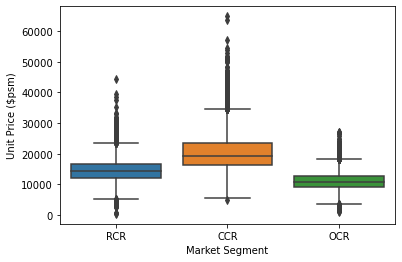

In [62]:
# Unit prices in CCR is higher than both RCR and OCR.
sns.boxplot(x="Market Segment", y="Unit Price ($psm)", data=privateDf)

<AxesSubplot:xlabel='Type', ylabel='Price ($)'>

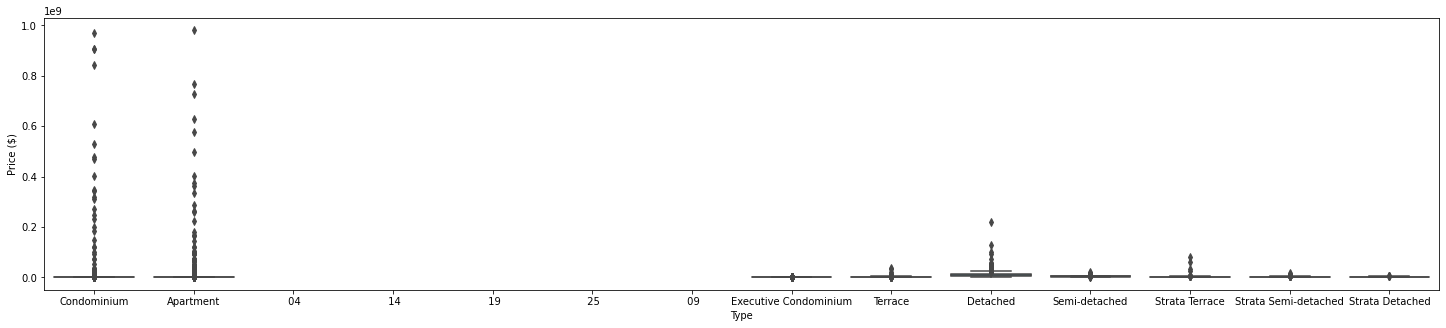

In [63]:
plt.figure(figsize=[25,5])

# So from here, we know there is something wrong with the type column.
# Regardless, one would expect that an actual landed properties will have outliers be have more resale values compared to condos and apartments though our boxplot says otherwise.
# Refer to another box plot below for values below 20 million.
sns.boxplot(x="Type", y="Price ($)", data=privateDf)

(0.0, 20000000.0)

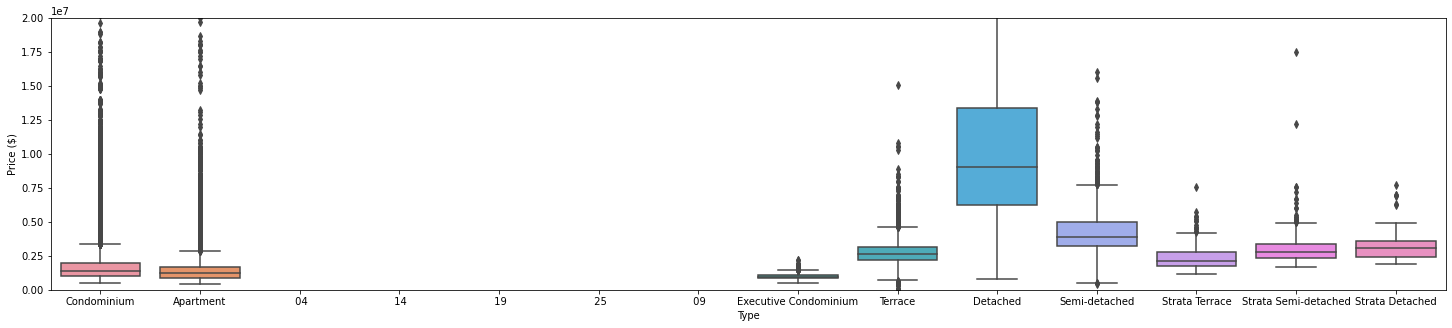

In [64]:
plt.figure(figsize=[25,5])

# Now over here, median resale value for detached houses are higher than other columns.
sns.boxplot(x="Type", y="Price ($)", data=privateDf)
plt.ylim(0,20000000)


<AxesSubplot:>

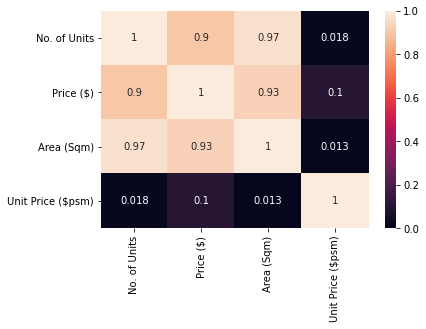

In [65]:
sns.heatmap(privateDf.corr(), vmin=0, vmax=1, annot=True)

In [66]:
# From here, there are sales regarding entire condos and apartments
privateDf['No. of Units'].nlargest(10)

28807    560.0
4332     436.0
28284    336.0
16579    330.0
45350    290.0
4194     288.0
29483    286.0
28996    244.0
35802    210.0
15470    200.0
Name: No. of Units, dtype: float64

## Data Preparation
- In this section, we will check if our data contains null/empty values and fill in empty data with mean values.
- We will also convert column data to correct data types.

In [67]:
# Drop project name and street name columns as they are irrelevant
# Drop S/N since we already have a index column
# Drop type of sale because we are only dealing with resale only
privateDf = privateDf.drop(['S/N','Project Name','Street Name','Type of Sale'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,-,93.0,Strata,41 to 45,21505.0,May-2021
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,-,141.0,Strata,01 to 05,16312.0,May-2021
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,-,60.0,Strata,36 to 40,20855.0,May-2021
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,-,169.0,Strata,16 to 20,14970.0,May-2021
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,-,73.0,Strata,01 to 05,15753.0,May-2021


In [68]:
# We check if any rows contain any useful value related to Nett Price ($)
# But turns out there is nothing relevant there
# So we drop that column
privateDf[privateDf['Nett Price ($)'] != '-']

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
6317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6318,04,05 & Type of Sale: Resale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
63890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
privateDf = privateDf.drop(['Nett Price ($)'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,93.0,Strata,41 to 45,21505.0,May-2021
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,141.0,Strata,01 to 05,16312.0,May-2021
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,60.0,Strata,36 to 40,20855.0,May-2021
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,169.0,Strata,16 to 20,14970.0,May-2021
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,73.0,Strata,01 to 05,15753.0,May-2021


In [70]:
# Some fields are empty
# In this case, we drop irrelevant rows
privateDf.isnull().sum()

Type                 277
Postal District      277
Market Segment       294
Tenure               298
No. of Units         294
Price ($)            294
Area (Sqm)           294
Type of Area         294
Floor Level          294
Unit Price ($psm)    294
Date of Sale         294
dtype: int64

In [71]:
row_has_NaN = privateDf.isnull().any(axis=1)
rows = privateDf[row_has_NaN]
rows.head(20)
# rows.info()

# Just by checking null values, we can tell that they are totally not related to our data at all.
# Just descriptions of the data located at the bottom of each csv files.
# Therefore, we just drop these rows.

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
6317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6318,04,05 & Type of Sale: Resale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# We drop empty rows here
privateDf = privateDf.dropna()
privateDf.isnull().sum()

Type                 0
Postal District      0
Market Segment       0
Tenure               0
No. of Units         0
Price ($)            0
Area (Sqm)           0
Type of Area         0
Floor Level          0
Unit Price ($psm)    0
Date of Sale         0
dtype: int64

In [73]:
# There is still plenty of rows left
privateDf.shape

(63597, 11)

In [74]:
# Convert month column to 'month' type
privateDf['Date of Sale'] = pd.to_datetime(privateDf['Date of Sale'],format='%b-%Y')
# Convert month to ordinal type so we can use the data for training our model
privateDf['Date of Sale'] = privateDf['Date of Sale'].map(dt.datetime.toordinal)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,93.0,Strata,41 to 45,21505.0,737911
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,141.0,Strata,01 to 05,16312.0,737911
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,60.0,Strata,36 to 40,20855.0,737911
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,169.0,Strata,16 to 20,14970.0,737911
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,73.0,Strata,01 to 05,15753.0,737911


## Feature Engineering
- One hot encode categorical columns for flat_models, town, storey_range, flat_type.
- We also extract information from the tenure column.

In [75]:
# Extracting info from tenure
tenureEx = privateDf["Tenure"].str.split(" ", n = 5, expand = True)
tenureEx.head()

,0,1,2,3,4,5
0,99,yrs,lease,commencing,from,2012
1,99,yrs,lease,commencing,from,1999
2,99,yrs,lease,commencing,from,2006
3,99,yrs,lease,commencing,from,2008
4,956,yrs,lease,commencing,from,1928


In [76]:
freeholdVal = tenureEx[tenureEx[0] == "Freehold"]
freeholdVal = freeholdVal.drop([1,2,3,4,5], axis=1)
freeholdVal.head()

,0
15,Freehold
16,Freehold
23,Freehold
33,Freehold
35,Freehold


In [77]:
# We retrieve rows without freehold
tenureInfo = tenureEx[tenureEx[0] != "Freehold"]
tenureDuration = tenureInfo.drop([1,2,3,4,5], axis=1)
tenureStartYear = tenureInfo.drop([0,1,2,3,4], axis=1)
tenureDuration.head()

,0
0,99
1,99
2,99
3,99
4,956


In [78]:
# Concat extract values to privatedf

privateDf ['Freehold']= pd.concat([freeholdVal], axis=0)
privateDf['Tenure Duration (Years)'] = pd.concat([tenureDuration], axis=0)
privateDf['Start Lease Date'] = pd.concat([tenureStartYear], axis=0)

# Fill null values with 'not freehold'
privateDf['Freehold'] = privateDf['Freehold'].fillna('Not Freehold')

#Convert start lease date to datetime format
privateDf['Start Lease Date'] = pd.to_datetime(privateDf['Start Lease Date'], errors='coerce')
# privateDf['isFreehold'] = tenureEx[tenureEx[0] == "Freehold"]p# rivateDf['isFreehold'] = ppd.to_numeric(privateDf['isFreehold'])

In [79]:
# Convert start lease date to ordinal type
privateDf['Start Lease Date'] = privateDf['Start Lease Date'].map(dt.datetime.toordinal)

# mappingFreehold = {'Freehold': 1, 'NaN':0}
# privateDf = privateDf.replace({'isFreehold':mappingFreehold})

In [80]:
# Fill tenure duration with 0 since it is freehold
privateDf['Tenure Duration (Years)'] = privateDf['Tenure Duration (Years)'].fillna(0)

In [81]:
privateDf['Tenure Duration (Years)'] = pd.to_numeric(privateDf['Tenure Duration (Years)'])

In [82]:
# Drop Tenure Column after extracting the information
privateDf = privateDf.drop(['Tenure'], axis=1)

In [83]:
privateDf.head()

,Type,Postal District,Market Segment,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale,Freehold,Tenure Duration (Years),Start Lease Date
0,Condominium,03,RCR,1.0,2000000.0,93.0,Strata,41 to 45,21505.0,737911,Not Freehold,99,734503
1,Condominium,04,RCR,1.0,2300000.0,141.0,Strata,01 to 05,16312.0,737911,Not Freehold,99,729755
2,Apartment,02,CCR,1.0,1251300.0,60.0,Strata,36 to 40,20855.0,737911,Not Freehold,99,732312
3,Condominium,03,RCR,1.0,2530000.0,169.0,Strata,16 to 20,14970.0,737911,Not Freehold,99,733042
4,Condominium,05,OCR,1.0,1150000.0,73.0,Strata,01 to 05,15753.0,737911,Not Freehold,956,703822


In [84]:
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63597 entries, 0 to 63880
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     63597 non-null  object 
 1   Postal District          63597 non-null  object 
 2   Market Segment           63597 non-null  object 
 3   No. of Units             63597 non-null  float64
 4   Price ($)                63597 non-null  float64
 5   Area (Sqm)               63597 non-null  float64
 6   Type of Area             63597 non-null  object 
 7   Floor Level              63597 non-null  object 
 8   Unit Price ($psm)        63597 non-null  float64
 9   Date of Sale             63597 non-null  int64  
 10  Freehold                 63597 non-null  object 
 11  Tenure Duration (Years)  63597 non-null  int64  
 12  Start Lease Date         63597 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 6.8+ MB


In [ ]:
# It appears that the number of Freehold coincides with the number of empty rows.
# tenureEx.isnull().sum()

In [85]:
# Standardised Postal District Naming
privateDf['Postal District'] = privateDf['Postal District'].replace({26.0: 26, 27.0: 27, 28.0: 28})

In [86]:
# One hot encode these categorical columns
privateDf = pd.get_dummies(privateDf, columns=['Type','Postal District', 'Market Segment','Type of Area','Floor Level','Freehold'])
privateDf.head()

,No. of Units,Price ($),Area (Sqm),Unit Price ($psm),Date of Sale,Tenure Duration (Years),Start Lease Date,Type_Apartment,Type_Condominium,Type_Detached,...,Floor Level_41 to 45,Floor Level_46 to 50,Floor Level_51 to 55,Floor Level_56 to 60,Floor Level_61 to 65,Floor Level_66 to 70,Floor Level_71 to 75,Floor Level_B1 to B5,Freehold_Freehold,Freehold_Not Freehold
0,1.0,2000000.0,93.0,21505.0,737911,99,734503,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,2300000.0,141.0,16312.0,737911,99,729755,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,1251300.0,60.0,20855.0,737911,99,732312,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,2530000.0,169.0,14970.0,737911,99,733042,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1150000.0,73.0,15753.0,737911,956,703822,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [87]:
# Create new feature called price per unit
privateDf['Price Per Unit ($/unit)'] = privateDf['Price ($)'] / privateDf['No. of Units']

In [88]:
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63597 entries, 0 to 63880
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   No. of Units                63597 non-null  float64
 1   Price ($)                   63597 non-null  float64
 2   Area (Sqm)                  63597 non-null  float64
 3   Unit Price ($psm)           63597 non-null  float64
 4   Date of Sale                63597 non-null  int64  
 5   Tenure Duration (Years)     63597 non-null  int64  
 6   Start Lease Date            63597 non-null  int64  
 7   Type_Apartment              63597 non-null  uint8  
 8   Type_Condominium            63597 non-null  uint8  
 9   Type_Detached               63597 non-null  uint8  
 10  Type_Executive Condominium  63597 non-null  uint8  
 11  Type_Semi-detached          63597 non-null  uint8  
 12  Type_Strata Detached        63597 non-null  uint8  
 13  Type_Strata Semi-detached   635

In [89]:
# pd.options.display.min_rows = 80
# print(privateDf.isnull().sum())

## Training Model - Regression
- Prob will decide which algo will fit the best for this project.
- Needs to have validation dataset as well

In [124]:
# X contains features
X = privateDf.drop(['Price Per Unit ($/unit)'], axis=1)

# y contains targets to be predicted
y = privateDf['Price Per Unit ($/unit)']

# 80% training data and 20% data for test data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, shuffle=True)

#### Linear Regression
We will use a simple linear regression alogrithm for this section.

In [125]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [126]:
# Predict results
y_predTrain = reg.predict(X_train)
y_predTest = reg.predict(X_test)

# MAE Computation
mae = mean_absolute_error(y_train, y_predTrain)
print("Mean Absolute Error on training data: {:.4f}".format(mae))

mae = mean_absolute_error(y_test, y_predTest)
print("Mean Absolute Error on test data: {:.4f}\n".format(mae))

# MSE Computation
mse = mean_squared_error(y_train, y_predTrain)
print("Mean Squared Error on training data: {:.4f}".format(mse))

mse = mean_squared_error(y_test, y_predTest)
print("Mean Squared Error on test data: {:.4f}\n".format(mse))

# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_train, y_predTrain))
print("Root Mean Squared Error on training data: {:.4f}".format(rmse))

rmse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Root Mean Squared Error on test data: {:.4f}\n".format(rmse))

# R Square Computation
r2 = r2_score(y_train, y_predTrain)
print("R Square value on training data: {:.4f}".format(r2))

r2 = r2_score(y_test, y_predTest)
print("R Square value on test data: {:.4f}".format(r2))

# exp = explained_variance_score(y_test, y_predTest)
# print("Explained variance score: {:.4f}".format(exp))

Mean Absolute Error on training data: 462276.1110
Mean Absolute Error on test data: 463678.6458

Mean Squared Error on training data: 1856490720357.5176
Mean Squared Error on test data: 1659782738504.1641

Root Mean Squared Error on training data: 1362530.9979
Root Mean Squared Error on test data: 1288325.5561

R Square value on training data: 0.6924
R Square value on test data: 0.7264


#### Results
- Mean Absolute Error on training data: 462317.8822
- Mean Absolute Error on test data: 463598.6863

- Mean Squared Error on training data: 1856457858240.7925
- Mean Squared Error on test data: 1659709744178.5479

- Root Mean Squared Error on training data: 1362518.9387
- Root Mean Squared Error on test data: 1288297.2266

- R Square value on training data: 0.6924
- R Square value on test data: 0.7264

### XGBoost
- We will be using XGBoost for this section.
- XGBoost is widely used among Kaggle competitions and often used on large-scale problems.
- Since XGBoost gives great performance and accuracy on regression and classification problems.
- Though we only use it for regression problems here.

In [127]:
xgb = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100, max_depth=3)

In [128]:
# Hyperparameters used to tune our model
param_grid = {'min_child_weight':range(1,4),'reg_alpha':range(1,4,2),'reg_lambda':range(2,8,2)}
gridModel = GridSearchCV(estimator=xgb, param_grid=param_grid)


# More fine tuning is needed


# Code below is used to cut down on memory needed to copy data
X_train = np.ascontiguousarray(X_train)
y_train = np.ascontiguousarray(y_train)

eval_metrics = ['rmse','rmsle','mae','mape']

# We fit the model here
gridModel.fit(X_train, y_train, eval_metric=eval_metrics)
# gridModel.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
         

In [129]:
# Here we see the best scores
best_score = gridModel.best_score_
print(best_score)

0.9880909003403968


Best Score: 0.9898867830258633

In [130]:
# And here we see the best hyperparameters
# I have tested using gamma parameter and its best at 0
best_params = gridModel.best_params_
print(best_params)

{'min_child_weight': 2, 'reg_alpha': 1, 'reg_lambda': 2}


Best parameters: {'gamma': 0, 'max_depth': 7, 'min_child_weight': 3, 'reg_alpha': 1}

In [131]:
# We save the model
best_model = gridModel.best_estimator_
print(best_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [133]:
# We save the model in pickel format
pickle.dump(best_model, open("xgb_private_resale.pickle", "wb"))

In [134]:
gridModel = pickle.load(open('xgb_private_resale.pickle', 'rb'))

In [117]:
# names = gridModel.
# print(names)

In [135]:
# Predict results
y_predTrain = gridModel.predict(X_train)
y_predTest = gridModel.predict(X_test)

# MAE Computation
mae = mean_absolute_error(y_train, y_predTrain)
print("Mean Absolute Error on training data: {:.4f}".format(mae))

mae = mean_absolute_error(y_test, y_predTest)
print("Mean Absolute Error on test data: {:.4f}\n".format(mae))

# MSE Computation
mse = mean_squared_error(y_train, y_predTrain)
print("Mean Squared Error on training data: {:.4f}".format(mse))

mse = mean_squared_error(y_test, y_predTest)
print("Mean Squared Error on test data: {:.4f}\n".format(mse))

# RMSE Computation
mse = np.sqrt(mean_squared_error(y_train, y_predTrain))
print("Root Mean Squared Error on training data: {:.4f}".format(mse))

mse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Root Mean Squared Error on test data: {:.4f}\n".format(mse))

# R Square Computation
r2 = r2_score(y_train, y_predTrain)
print("R Square value on training data: {:.4f}".format(r2))

r2 = r2_score(y_test, y_predTest)
print("R Square value on test data: {:.4f}".format(r2))

# exp = explained_variance_score(y_train, pred)
# print("Explained variance score: {:.4f}".format(exp))

Mean Absolute Error on training data: 27907.3952
Mean Absolute Error on test data: 32177.4103

Mean Squared Error on training data: 3256501660.4001
Mean Squared Error on test data: 78767126454.5522

Root Mean Squared Error on training data: 57065.7661
Root Mean Squared Error on test data: 280654.8173

R Square value on training data: 0.9995
R Square value on test data: 0.9870


#### Results
- Mean Absolute Error on training data: 27907.3952
- Mean Absolute Error on test data: 32177.4103

- Mean Squared Error on training data: 3256501660.4001
- Mean Squared Error on test data: 78767126454.5522

- Root Mean Squared Error on training data: 57065.7661
- Root Mean Squared Error on test data: 280654.8173

- R Square value on training data: 0.9995
- R Square value on test data: 0.9870

In [ ]:
# resultDf = pd.DataFrame(gridModel.cv_results_) #gridModel.cv_results_
# resultDf.head(20)

In [ ]:
# y.describe().T

### Chosen ML Model
- XGBoost will be chosen for predicting housing resale prices as it performs better than the simple linear regression.
- Reasons
    - Mean Absolute Error is lower by half using XGBoost
    - Root Mean Squared Error is lower by half using XGBoost
    - Explained Variance Score is higher using XGBoost